In the name of god

**ANN Project - Fruit Classification**

**By: Niki Pourazin**


# Loading Data Methods

In the first step, taking the provided original asset of the project, We change it so we  have a function implemented in a seperate python file. Then, we import the needed method to use it.
The method for loading data is as follows.

In [1]:
import numpy as np
import random
import pickle


def load_and_get_set(test_or_train, feature_file_path, label_file_path):
    threshold = 52.3
    if test_or_train == "test":
        threshold = 48

    # loading set features
    f = open(feature_file_path, "rb")
    test_set_features2 = pickle.load(f)
    f.close()

    # reducing feature vector length
    features_STDs = np.std(a=test_set_features2, axis=0)
    test_set_features = test_set_features2[:, features_STDs > threshold]

    # changing the range of data between 0 and 1
    test_set_features = np.divide(test_set_features, test_set_features.max())

    # loading set labels
    f = open(label_file_path, "rb")
    test_set_labels = pickle.load(f)
    f.close()

    # preparing our training or test sets - joining datasets and lables
    myset = []

    for i in range(len(test_set_features)):
        label = np.array([0, 0, 0, 0])
        label[int(test_set_labels[i])] = 1
        label = label.reshape(4, 1)
        myset.append((test_set_features[i].reshape(102, 1), label))

    # shuffle
    random.shuffle(myset)

    # print size
    print("The loaded set's size: ", len(myset))

    return myset

This method's functionality is also shown in the next secton, as it is used. 

# Implementing Feed Forward

First of all, we retreive the train set by using the previously implemented methods in Loading_Datasets.py. The methods functionaliy is testes as it prints the correct data size (here is 1962)

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ANN_Project_Assets import Loading_Datasets as ld

train_set = ld.load_and_get_set(test_or_train="train",
                                feature_file_path="ANN_Project_Assets/Datasets/train_set_features.pkl",
                                label_file_path="ANN_Project_Assets/Datasets/train_set_labels.pkl")

layer_sizes = [len(train_set[0][0]), 150, 60, 4]  # [102, 150, 60, 4]

The loaded set's size:  1962


Then, we declare the weight and bias variable; The weight and bias for between layers k and k+1 are notated by W[k] and B[k]. The weight values are filled with random numbers between 0 to 1, while as for the bias values, they are all initially set to zero. 

The initialize_values() function will be used a lot, when reseting the values of weights and biases. 

In [66]:
B = []
W = []
data_size = 200 # number of train set elements taken from the train set

def initialize_values():
    global W
    global B
    
    # There are 4 layers, between each two consecutive layers, there needs to be a weight matrix
    W = [
        np.random.normal(size=(layer_sizes[1], layer_sizes[0])),  # weights between layer 0 and 1, aka W[0]
        np.random.normal(size=(layer_sizes[2], layer_sizes[1])),  # weights between layer 1 and 2, aka W[1]
        np.random.normal(size=(layer_sizes[3], layer_sizes[2]))  # weights between layer 2 and 3, aka W[2]
    ]

    # Initialize bias to 0, for every layer.
    B = [
        np.zeros((layer_sizes[1], 1)),  # bias vector between layer 0 and 1, aka B[0]
        np.zeros((layer_sizes[2], 1)),  # bias vector between layer 1 and 2, aka B[1]
        np.zeros((layer_sizes[3], 1)),  # bias vector between layer 2 and 3, aka B[2]
    ]


initialize_values()

We would need two methods to use in the feed forwrd implementation.
one is the activation function, here we implement the sigmoid function and use it later as the acivation function.
the other is used for checking the labels, used to compare the calculated and actual values of the labels.

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def check_accuracy(calculated_labels, correct_labels):
    calculated_ans = np.where(calculated_labels == np.amax(calculated_labels))
    correct_ans = np.where(correct_labels == np.amax(correct_labels))

    return calculated_ans == correct_ans

Here we implement a function that runs the NN once in feed forward manner. to do this, using the data_size varible which we had previously set to 200, we take 200 train data sapmles. Then, for each of then, we give the 102 features to the first layer ans as we had set the weight to random values, for each layer we first use matrix multiplication between the weights and the previous layer values and then add the bias to them. (which, here it is 0, but we shall use the full formula as the function is to be called upon later as well.) 
As the activation function is said to be sigmoid (previously implemented), we use the values calculated before as the input of the activation function, setting the output as the value for the corresponding node in the NN.
Once all the network layers have been traversed, using the check_accuracy method(previously implemented), we check if the network was able to find the correct answer for this train data sample or not. if it was, a counter is incremented.
at last, the accuracy is caluculated as the probability of having this network get the correct answer for some data. (calculated by the share of correct answers in the whole data_size samples)


In [5]:
def run_feed_forward():
    correct_ans_count = 0  # number of correct answers, initialized at 0

    for td in train_set[:data_size]:
        z = [
            np.zeros((layer_sizes[0], 1)),
            np.zeros((layer_sizes[1], 1)),
            np.zeros((layer_sizes[2], 1)),
            np.zeros((layer_sizes[3], 1))

        ]

        # values of the first layer (0th), initialized as the train data
        z[0] = td[0]
        np.reshape(z[0], (102, 1))
        
        for i in range(1, 4):
            # for each next layer, z is calculated as discussed below
            z[i] = sigmoid(W[i - 1] @ z[i - 1] + B[i - 1])

        if check_accuracy(z[3], td[1]):
            correct_ans_count += 1

    return correct_ans_count / data_size


In [67]:
print("Feed Forward Accuracy: ", run_feed_forward())

Feed Forward Accuracy:  0.235


As expected, accuracy is very low and around 0.25 (as in a random choice of 1 in 4)
In the feed forward network, implemented above, the system has no ability in "learning". In the next step, we make it so the NN can adjust the weights for better and better results. 

# Back Propagation

In [7]:
def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


The weights and biases get initilized again. Hyperparameters are to be assigned with some values. 

In [53]:
initialize_values()


# Hyper parameters
batch_size = 10
learning_rate = 1
epoch_number = 5

costs = []
data_size = 200


The implementation for back propagation is provided below. 
In this method, in order to find the fastest way to decrease the cost, we simply move in the exact opposite way of the Gradient Descent. (As the Gradient Descent is a method of fainding the fastest way of reaching the maximum cost). As this method shows us correct the direction, we also declare a learning rate indicating the speed of moving. The two values mentioned are to be multiplied and their result would be deducte from the prevoius values of bias and weight. therefore,

For the weight:
$$ W = W - \eta \bigtriangledown cost $$
For the bias:
$$  B = B - \eta \bigtriangledown cost $$

We also use batches and epoches as indicated in the code below, having a cost value calculated at the end of each epoch. keeping all those values in the costs list, they are plotted at the end of the program.
Accuracy is calculated by running a feedforward again.


In [28]:
def run_back_propagated():
    global costs
    trimmed_train_set = train_set[:data_size]
    
    costs = []

    for i in range(0, epoch_number):
        # shuffle the train set
        random.shuffle(trimmed_train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, data_size, batch_size)]
        for batch in batches:

            grad_W = [
                np.random.normal(size=(layer_sizes[1], layer_sizes[0])),
                np.random.normal(size=(layer_sizes[2], layer_sizes[1])),
                np.random.normal(size=(layer_sizes[3], layer_sizes[2]))
            ]

            grad_B = [
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            for td in batch:
                z = [
                    np.zeros((layer_sizes[0], 1)),
                    np.zeros((layer_sizes[1], 1)),
                    np.zeros((layer_sizes[2], 1)),
                    np.zeros((layer_sizes[3], 1))
                ]

                # values of the first layer (0th), initialized as the train data
                z[0] = td[0]
                np.reshape(z[0], (102, 1))

                for j in range(1, 4):
                    # for each next layer, z is calculated as discussed below
                    z[j] = sigmoid(W[j - 1] @ z[j - 1] + B[j - 1])

                # ** layer 4
                for j in range(layer_sizes[3]):
                    grad_B[2][j, 0] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0])  # bias layer 4

                    for k in range(layer_sizes[2]):  # weight layer 4
                        grad_W[2][j, k] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0]) * z[2][k, 0]

                delta_2 = np.zeros((layer_sizes[2], 1))
                for k in range(layer_sizes[2]):
                    for j in range(layer_sizes[3]):
                        delta_2[k, 0] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0]) * W[2][j, k]

                # ** layer 3
                for j in range(layer_sizes[2]):
                    grad_B[1][j, 0] += delta_2[j, 0] * d_sigmoid(z[2][j, 0])  # bias layer 3

                    for k in range(layer_sizes[1]):  # weight layer 3
                        grad_W[1][j, k] += delta_2[j, 0] * d_sigmoid(z[2][j, 0]) * z[1][k, 0]

                delta_1 = np.zeros((layer_sizes[1], 1))
                for k in range(layer_sizes[1]):
                    for j in range(layer_sizes[2]):
                        delta_1[k, 0] += delta_2[j, 0] * d_sigmoid(z[2][j, 0]) * W[1][j, k]

                # ** layer 2
                for j in range(layer_sizes[1]):
                    grad_B[0][j, 0] += delta_1[j, 0] * d_sigmoid(z[1][j, 0])  # bias layer 2

                    for k in range(layer_sizes[0]):  # weight layer 2
                        grad_W[0][j, k] += delta_1[j, 0] * d_sigmoid(z[1][j, 0]) * z[0][k, 0]

            # update, using the gradient
            for ind in range(0, 3):
                W[ind] -= learning_rate * (grad_W[ind] / batch_size)
                B[ind] -= learning_rate * (grad_B[ind] / batch_size)

        cost = 0
        for td in trimmed_train_set:
            z = [
                np.zeros((layer_sizes[0], 1)),
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            # values of the first layer (0th), initialized as the train data
            z[0] = td[0]
            np.reshape(z[0], (102, 1))

            for it in range(1, 4):
                # for each next layer, z is calculated as discussed below
                z[it] = sigmoid(W[it - 1] @ z[it - 1] + B[it - 1])

            for j in range(layer_sizes[3]):
                cost += np.power((z[3][j, 0] - td[1][j, 0]), 2)

        cost /= data_size
        costs.append(cost)

Back Propagation Accuracy:  1.0
Wall time: 2min 27s


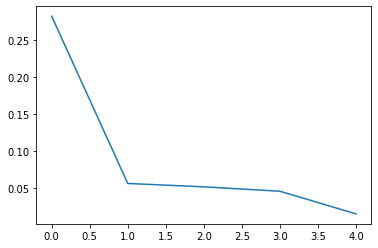

In [50]:
%%time

run_back_propagated()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())

Then, we just run it once again. 

Back Propagation Accuracy:  0.99
Wall time: 2min 25s


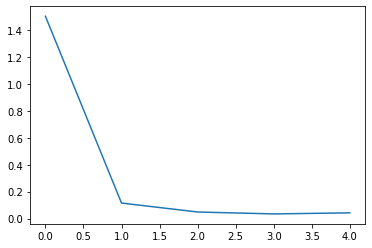

In [46]:
%%time
initialize_values()
costs = []
run_back_propagated()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())

# Vectorization

We reset hyperparameters just in case.

In [47]:
batch_size = 10
learning_rate = 1
epoch_number = 5
costs = []

initialize_values()

In this section, We then use matrix operation such as @ (matrix multipulation) instead of looping. This actually helps, as the implementation of these functions are done in a way that makes them very ver efficient ans thus, causing the running speed go significantly higher. We call this process vectorization, as we treat our datas like vectors and use vector operations on them.

The code below is the implementation of the vectorized version of previous section code.

In [15]:
def run_vectorized_back_propagation():
    global costs
    
    trimmed_train_set = train_set[:data_size]
    costs = []
    
    for i in range(0, epoch_number):
        # shuffle the train set
        random.shuffle(trimmed_train_set)
        
        batches = [train_set[x:x + batch_size] for x in range(0, data_size, batch_size)]
        for batch in batches:

            grad_W = [
                np.random.normal(size=(layer_sizes[1], layer_sizes[0])),
                np.random.normal(size=(layer_sizes[2], layer_sizes[1])),
                np.random.normal(size=(layer_sizes[3], layer_sizes[2]))
            ]

            grad_B = [
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            for td in batch:
                z = [
                    np.zeros((layer_sizes[0], 1)),
                    np.zeros((layer_sizes[1], 1)),
                    np.zeros((layer_sizes[2], 1)),
                    np.zeros((layer_sizes[3], 1))
                ]

                # values of the first layer (0th), initialized as the train data
                z[0] = td[0]
                np.reshape(z[0], (102, 1))

                for j in range(1, 4):
                    # for each next layer, z is calculated as discussed below
                    z[j] = sigmoid(W[j - 1] @ z[j - 1] + B[j - 1])

                # ** layer 4 to 3
                grad_B[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1]))  # bias layer 4
                grad_W[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1])) @ np.transpose(z[2])

                # delta_2 = np.zeros((layer_sizes[2], 1))
                delta_2 = (np.transpose(W[2])) @ (2 * d_sigmoid(z[3]) * (z[3] - td[1]))

                # ** layer 3 to 2
                grad_B[1] += delta_2 * d_sigmoid(z[2])  # bias layer 3
                grad_W[1] += (delta_2 * d_sigmoid(z[2])) @ np.transpose(z[1])

                # delta_1 = np.zeros((layer_sizes[1], 1))
                delta_1 = np.transpose(W[1]) @ (2 * d_sigmoid(z[2]) * delta_2)

                # ** layer 2 to 1
                grad_B[0] += delta_1 * d_sigmoid(z[1])  # bias layer 2
                grad_W[0] += delta_1 * d_sigmoid(z[1]) @ np.transpose(z[0])

            # update, using the gradient
            for ind in range(0, 3):
                W[ind] -= learning_rate * (grad_W[ind] / batch_size)
                B[ind] -= learning_rate * (grad_B[ind] / batch_size)

        cost = 0
        for td in trimmed_train_set:
            z = [
                np.zeros((layer_sizes[0], 1)),
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            # values of the first layer (0th), initialized as the train data
            z[0] = td[0]
            np.reshape(z[0], (102, 1))

            for it in range(1, 4):
                # for each next layer, z is calculated as discussed below
                z[it] = sigmoid(W[it - 1] @ z[it - 1] + B[it - 1])

            for j in range(layer_sizes[3]):
                cost += np.power((z[3][j, 0] - td[1][j, 0]), 2)

        cost /= data_size
        costs.append(cost)


We get to use the method above, in the code below. Also, to get the accuracy we re-run the feedforward method. 

Back Propagation Accuracy:  0.995
Wall time: 578 ms


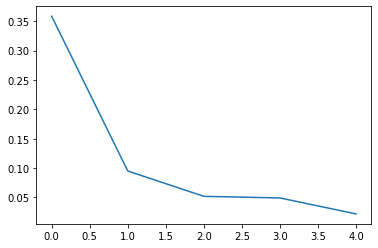

In [46]:
%%time
run_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())


First, Let's compare the speed!!

The looping version took about 2-3 MINUTES on each run, but the vectorized version takes at most 1-2 SECONDS (it some times even takes less than a second). This is a very significant decrease in time as the non-vectorized-time : vectorized-time ratio is about 1:0.008 which is at least 118 times faster!

We run it again... This time we have 20 epochs.

Back Propagation Accuracy:  1.0
Wall time: 2.12 s


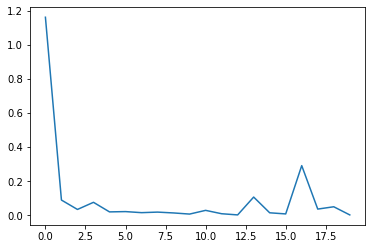

In [36]:
%%time
batch_size = 10
learning_rate = 1
epoch_number = 20
costs = []
initialize_values()

run_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())


We can see that raising the number of epochs while having a big learning rate (such as 1) may backfire. To show the point better, we run the code below with 50 epochs.

Back Propagation Accuracy:  1.0
Wall time: 5.23 s


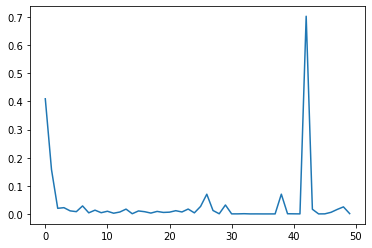

In [40]:
%%time
batch_size = 10
learning_rate = 1
epoch_number = 50
costs = []
initialize_values()

run_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())

Now, we plot more than a network-run in a graph, i.e. We run the code above for ten times and get an average accuracy from it. 

Accuracy on round:  0   =   1.0
Accuracy on round:  1   =   1.0
Accuracy on round:  2   =   1.0
Accuracy on round:  3   =   0.995
Accuracy on round:  4   =   1.0
Accuracy on round:  5   =   0.995
Accuracy on round:  6   =   0.995
Accuracy on round:  7   =   0.985
Accuracy on round:  8   =   1.0
Accuracy on round:  9   =   0.99
Average accuracy:  0.9960000000000001
Wall time: 5.47 s


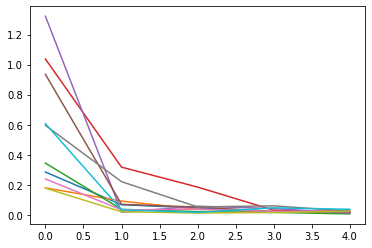

In [48]:
%%time
batch_size = 10
learning_rate = 0.8
epoch_number = 5
number_of_runs = 10
sum_of_all_accuracies = 0

for i in range(0, number_of_runs): 
    costs = []
    initialize_values()

    run_vectorized_back_propagation()

    epoch_size = [x for x in range(epoch_number)]
    plt.plot(epoch_size, costs)
    acc = run_feed_forward()
    print("Accuracy on round: ", i, "  =  ", acc)
    sum_of_all_accuracies += acc

print("Average accuracy: ", sum_of_all_accuracies/number_of_runs)

We also plot 3 runs of epochs on the same graph since the details are easier to see. 

Back Propagation Accuracy:  1.0
Back Propagation Accuracy:  1.0
Back Propagation Accuracy:  1.0
Wall time: 6.18 s


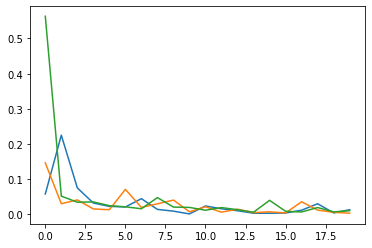

In [57]:
%%time
batch_size = 10
learning_rate = 0.8
epoch_number = 20

for i in range(1, 4): 
    costs = []
    initialize_values()

    run_vectorized_back_propagation()

    epoch_size = [x for x in range(epoch_number)]
    plt.plot(epoch_size, costs)
    print("Back Propagation Accuracy: ", run_feed_forward())

# Testing

First, we set the datasize to take all our data and reset hyperparameters.

In [104]:
data_size = len(train_set)
batch_size = 10
learning_rate = 1
epoch_number = 10

Then, we load the test data set in test_set and re-initialize the matrices.

In [105]:
test_set = ld.load_and_get_set(test_or_train="test",
                               feature_file_path="ANN_Project_Assets/Datasets/test_set_features.pkl",
                               label_file_path="ANN_Project_Assets/Datasets/test_set_labels.pkl")

initialize_values()
costs = []

The loaded set's size:  662


We run tests in simple feedforward manner. In each testing, we train the network from scratch and then get the accuracy for both train and test data. 

In [99]:
def run_test():
    correct_ans_count = 0  # number of correct answers, initialized at 0

    for td in test_set:
        z = [
            np.zeros((layer_sizes[0], 1)),
            np.zeros((layer_sizes[1], 1)),
            np.zeros((layer_sizes[2], 1)),
            np.zeros((layer_sizes[3], 1))
        ]

        # values of the first layer (0th), initialized as the train data
        z[0] = td[0]
        np.reshape(z[0], (102, 1))

        for i in range(1, 4):
            # for each next layer, z is calculated as discussed below
            z[i] = sigmoid(W[i - 1] @ z[i - 1] + B[i - 1])

        if check_accuracy(z[3], td[1]):
            correct_ans_count += 1

    return correct_ans_count / len(test_set)

for i in range(0, 10):
    initialize_values()
    costs = []
    run_vectorized_back_propagation()
    print("Train Accuracy: ", run_feed_forward())
    print("Test Accuracy: ", run_test())
    print("-----------------------")

Train Accuracy:  1.0
Test Accuracy:  0.9984894259818731
-----------------------
Train Accuracy:  1.0
Test Accuracy:  0.9894259818731118
-----------------------
Train Accuracy:  1.0
Test Accuracy:  0.9879154078549849
-----------------------
Train Accuracy:  0.9989806320081549
Test Accuracy:  0.9848942598187311
-----------------------
Train Accuracy:  1.0
Test Accuracy:  0.9969788519637462
-----------------------
Train Accuracy:  0.972986748216106
Test Accuracy:  0.8474320241691843
-----------------------
Train Accuracy:  1.0
Test Accuracy:  1.0
-----------------------
Train Accuracy:  1.0
Test Accuracy:  0.9274924471299094
-----------------------
Train Accuracy:  0.9984709480122325
Test Accuracy:  0.9969788519637462
-----------------------
Train Accuracy:  1.0
Test Accuracy:  1.0
-----------------------


We can see that both accuracies for the train and test data are petty high (higher than 90%), as anticipated.

Now we run for 10 times to get the average values and average costs plot. 

Train Average Accuracy:  0.9964322120285424
Test Average Accuracy:  0.9862537764350453


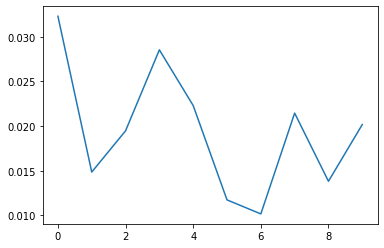

In [106]:
test_sum = 0
train_sum = 0
costs_array = []
avg_cost = [0] * 10


for i in range(0, 10):
    initialize_values()
    costs = []
    run_vectorized_back_propagation()
    train_sum += run_feed_forward()
    test_sum += run_test()
    
    costs_array.append(costs)


for j in range(0, epoch_number):
    for i in range(0, 10):
        avg_cost[j] += costs_array[i][j]
    avg_cost[j]/=10
    
epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, avg_cost)

print("Train Average Accuracy: ", train_sum/10)
print("Test Average Accuracy: ", test_sum/10)

Train Average Accuracy:  0.9992864424057085
Test Average Accuracy:  0.9953172205438067


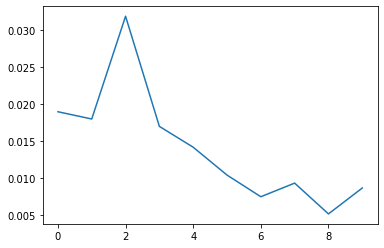

In [100]:
test_sum = 0
train_sum = 0
costs_array = []
avg_cost = [0] * 10


for i in range(0, 10):
    initialize_values()
    costs = []
    run_vectorized_back_propagation()
    train_sum += run_feed_forward()
    test_sum += run_test()
    
    costs_array.append(costs)


for j in range(0, epoch_number):
    for i in range(0, 10):
        avg_cost[j] += costs_array[i][j]
    avg_cost[j]/=10
    
epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, avg_cost)

print("Train Average Accuracy: ", train_sum/10)
print("Test Average Accuracy: ", test_sum/10)

# Additional Parts

## Part 1: Learning Rates

Many different values of learning rates have been used and tested to show that generally, the value learning_rate = 1 which was originally used, is too great and a little smaller value might help better results.
Generally, A too high learning rate will make the learning jump over minima but a too low learning rate will either take too long to converge or get stuck in an undesirable local minimum. That is way finding an appropriate value for the learning rate, or say, the speed of moving toward the goal, is an important task. 

In [16]:
batch_size = 10
learning_rate = 1
epoch_number = 5
costs = []

First we check the some more probable range (chosen by instinct!) of 0.5 to 3 to see which range should we check next. 

Accuracy For eta:  3  is :  0.975


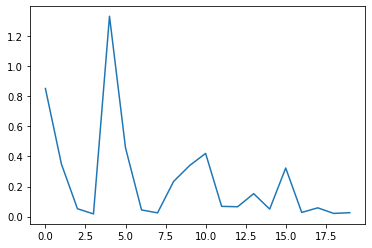

Accuracy For eta:  2.5  is :  1.0


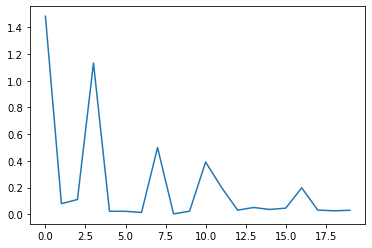

Accuracy For eta:  2.0  is :  1.0


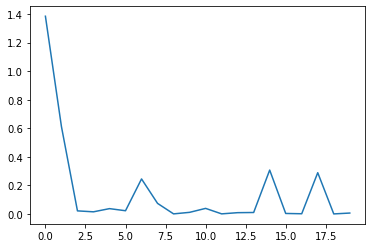

Accuracy For eta:  1.5  is :  1.0


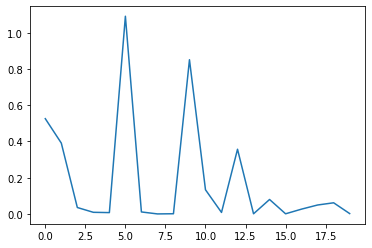

Accuracy For eta:  1.0  is :  1.0


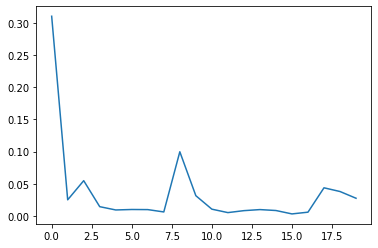

Accuracy For eta:  0.5  is :  1.0


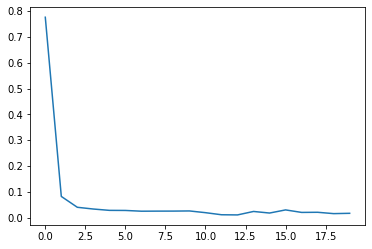

Wall time: 13.1 s


In [21]:
%%time
batch_size = 10
learning_rate = 3
epoch_number = 20

for i in range(1, 7): 
    costs = []
    initialize_values()

    run_vectorized_back_propagation()
    
    epoch_size = [x for x in range(epoch_number)]
    plt.plot(epoch_size, costs)
    
    print("Accuracy For eta: ",learning_rate, " is : ", run_feed_forward())
    plt.show()
    
    learning_rate -= 0.5

We conclude the range 0 to 1 contains better result so we check that range with less granularity. 

Accuracy For eta:  1  is :  0.985


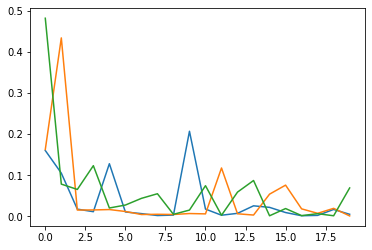

Accuracy For eta:  0.8  is :  0.98


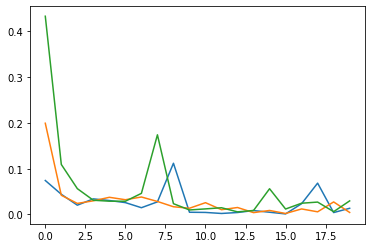

Accuracy For eta:  0.6000000000000001  is :  0.985


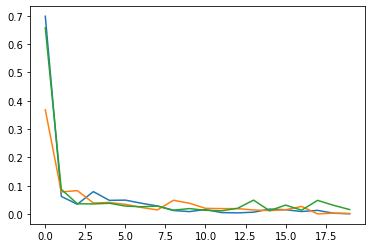

Accuracy For eta:  0.4000000000000001  is :  0.985


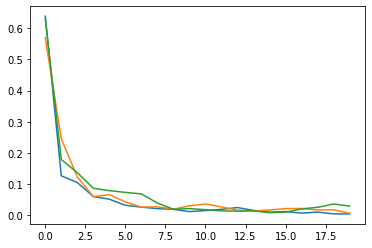

Accuracy For eta:  0.20000000000000007  is :  1.0


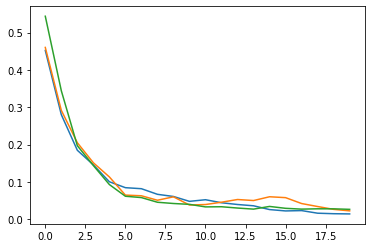

Wall time: 31.8 s


In [25]:
%%time
batch_size = 10
learning_rate = 1
epoch_number = 20

for i in range(1, 6): 
    for i in range (1, 4):
        costs = []
        initialize_values()

        run_vectorized_back_propagation()

        epoch_size = [x for x in range(epoch_number)]
        plt.plot(epoch_size, costs)
    
    print("Accuracy For eta: ",learning_rate, " is : ", run_feed_forward())
    plt.show()
    
    learning_rate -= 0.2

As we can see, as the learning rate lessens, the costs decrease slower but also the swinging effect gets less so we can conclude the highest learning rate where we see less swingings but also the speed is not too slow. in the graphs above we can see that on values lower than or equal to 0.6, the swinging effect decreases significantly. also, for values about 0.2, the slope is showing that we are wasting time by reducing the rate. 

Concluding from the statements above, **We can say the best rate seems to be a value around 0.4, or maybe a little more, like 0.5.**

## Part 2: More Sophisticated ways!

As explained in Additional - Part 1, learning rate must not be too high, as it causes jumping over the goal, but also not too low. There is never a guarantee that you will not get stuck in a local optimum, sadly. One of the ways of avoiding a local minima at a good cance (not guaranteed) is to gradually reduce the learning rate, then increase it and slowly draw it down, again, several times. Raising the learning rate reduces the stability of the algorithm, but gives the algorithm the ability to jump out of a local optimum. This is closely related to simulated annealing. In the other words, every once in a while, we take some jumps to somewhere else so the chances of getting stuck in a local optimum gets lower. ofcourse, many papers are written on this topic and a best way to guarantee this avoidance is yet to be found.

Some useful recources:
https://ieeexplore.ieee.org/document/9164747





We use the formula below for calculating new learning rate. first we get a random number between 0 to 2 and then we add a small epsilon like 0.000001 in case the random number was 0.

In [130]:
learning_rate *= (np.random.random() * 2 + 0.000001)

Therefore, The solution above can be implemented this way. We change the learning rate every epoch, but this can be done at random timings or maybe even every batch (depending on the batch size, this may be a bit overkill)

In [131]:
def run_stimulated_annealing_vectorized_back_propagation():
    global costs
    global learning_rate
    
    trimmed_train_set = train_set[:data_size]
    costs = []
    
    for i in range(0, epoch_number):
        # shuffle the train set
        random.shuffle(trimmed_train_set)
        learning_rate *= (np.random.random() * 2 + 0.000001)

        batches = [train_set[x:x + batch_size] for x in range(0, data_size, batch_size)]
        for batch in batches:
            
            
            grad_W = [
                np.random.normal(size=(layer_sizes[1], layer_sizes[0])),
                np.random.normal(size=(layer_sizes[2], layer_sizes[1])),
                np.random.normal(size=(layer_sizes[3], layer_sizes[2]))
            ]

            grad_B = [
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            for td in batch:
                z = [
                    np.zeros((layer_sizes[0], 1)),
                    np.zeros((layer_sizes[1], 1)),
                    np.zeros((layer_sizes[2], 1)),
                    np.zeros((layer_sizes[3], 1))
                ]

                # values of the first layer (0th), initialized as the train data
                z[0] = td[0]
                np.reshape(z[0], (102, 1))

                for j in range(1, 4):
                    # for each next layer, z is calculated as discussed below
                    z[j] = sigmoid(W[j - 1] @ z[j - 1] + B[j - 1])

                # ** layer 4 to 3
                grad_B[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1]))  # bias layer 4
                grad_W[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1])) @ np.transpose(z[2])

                # delta_2 = np.zeros((layer_sizes[2], 1))
                delta_2 = (np.transpose(W[2])) @ (2 * d_sigmoid(z[3]) * (z[3] - td[1]))

                # ** layer 3 to 2
                grad_B[1] += delta_2 * d_sigmoid(z[2])  # bias layer 3
                grad_W[1] += (delta_2 * d_sigmoid(z[2])) @ np.transpose(z[1])

                # delta_1 = np.zeros((layer_sizes[1], 1))
                delta_1 = np.transpose(W[1]) @ (2 * d_sigmoid(z[2]) * delta_2)

                # ** layer 2 to 1
                grad_B[0] += delta_1 * d_sigmoid(z[1])  # bias layer 2
                grad_W[0] += delta_1 * d_sigmoid(z[1]) @ np.transpose(z[0])

            # update, using the gradient
            for ind in range(0, 3):
                W[ind] -= learning_rate * (grad_W[ind] / batch_size)
                B[ind] -= learning_rate * (grad_B[ind] / batch_size)

        cost = 0
        for td in trimmed_train_set:
            z = [
                np.zeros((layer_sizes[0], 1)),
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            # values of the first layer (0th), initialized as the train data
            z[0] = td[0]
            np.reshape(z[0], (102, 1))

            for it in range(1, 4):
                # for each next layer, z is calculated as discussed below
                z[it] = sigmoid(W[it - 1] @ z[it - 1] + B[it - 1])

            for j in range(layer_sizes[3]):
                cost += np.power((z[3][j, 0] - td[1][j, 0]), 2)

        cost /= data_size
        costs.append(cost)


Stimulated Annealing Accuracy:  1.0


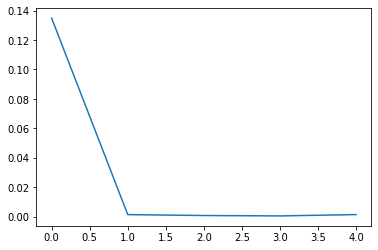

In [132]:
batch_size = 10
learning_rate = 1
epoch_number = 5
costs = []
initialize_values()

run_stimulated_annealing_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Stimulated Annealing Accuracy: ", run_feed_forward())

## Part 3: using Softmax 

# Some other runs

Back Propagation Accuracy:  1.0
Wall time: 1.1 s


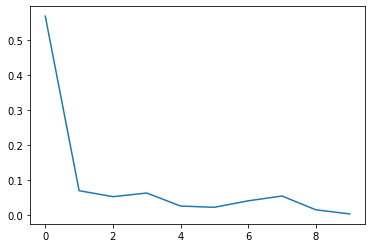

In [21]:
%%time
batch_size = 10
learning_rate = 1
epoch_number = 20
costs = []
initialize_values()

run_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
# print(len(epoch_size), len(costs))
plt.plot(epoch_size, costs)
# plt.plot(costs)
# plt.show()
print("Back Propagation Accuracy: ", run_feed_forward())


Back Propagation Accuracy:  0.985
Back Propagation Accuracy:  1.0
Back Propagation Accuracy:  1.0
Wall time: 1.64 s


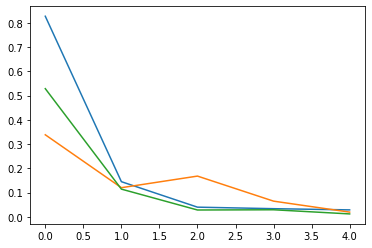

In [17]:
%%time
batch_size = 10
learning_rate = 0.8
epoch_number = 5

for i in range(1, 4): 
    costs = []
    initialize_values()

    run_vectorized_back_propagation()

    epoch_size = [x for x in range(epoch_number)]
    plt.plot(epoch_size, costs)
    print("Back Propagation Accuracy: ", run_feed_forward())

Back Propagation Accuracy:  0.97
Back Propagation Accuracy:  0.975
Back Propagation Accuracy:  1.0
Wall time: 1.67 s


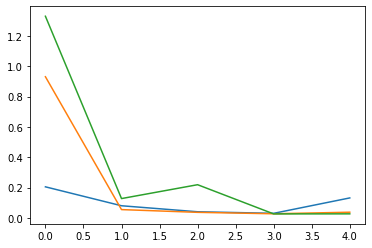

In [23]:
%%time
batch_size = 10
learning_rate = 0.8
epoch_number = 5

for i in range(1, 4): 
    costs = []
    initialize_values()

    run_vectorized_back_propagation()

    epoch_size = [x for x in range(epoch_number)]
    plt.plot(epoch_size, costs)
    print("Back Propagation Accuracy: ", run_feed_forward())

Back Propagation Accuracy:  0.995
Wall time: 615 ms


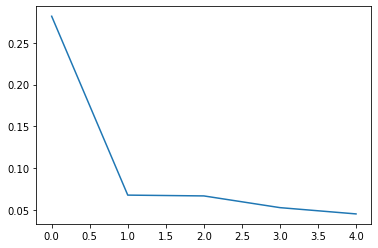

In [49]:
%%time
batch_size = 10
learning_rate = 0.8
epoch_number = 10
costs = []
# There are 4 layers, between each two consecutive layers, there needs to be a weight matrix
W = [
    np.random.normal(size=(layer_sizes[1], layer_sizes[0])),  # weights between layer 0 and 1, aka W[0]
    np.random.normal(size=(layer_sizes[2], layer_sizes[1])),  # weights between layer 1 and 2, aka W[1]
    np.random.normal(size=(layer_sizes[3], layer_sizes[2]))  # weights between layer 2 and 3, aka W[2]
]

# Initialize bias to 0, for every layer.
B = [
    np.zeros((layer_sizes[1], 1)),  # bias vector between layer 0 and 1, aka B[0]
    np.zeros((layer_sizes[2], 1)),  # bias vector between layer 1 and 2, aka B[1]
    np.zeros((layer_sizes[3], 1)),  # bias vector between layer 2 and 3, aka B[2]
]

def run_vectorized_back_propagation():
    data_size = 200
    trimmed_train_set = train_set[:data_size]

    for i in range(0, epoch_number):
        # shuffle the train set
        random.shuffle(trimmed_train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, data_size, batch_size)]
        for batch in batches:

            grad_W = [
                np.random.normal(size=(layer_sizes[1], layer_sizes[0])),
                np.random.normal(size=(layer_sizes[2], layer_sizes[1])),
                np.random.normal(size=(layer_sizes[3], layer_sizes[2]))
            ]

            grad_B = [
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            for td in batch:
                z = [
                    np.zeros((layer_sizes[0], 1)),
                    np.zeros((layer_sizes[1], 1)),
                    np.zeros((layer_sizes[2], 1)),
                    np.zeros((layer_sizes[3], 1))
                ]

                # values of the first layer (0th), initialized as the train data
                z[0] = td[0]
                np.reshape(z[0], (102, 1))

                for j in range(1, 4):
                    # for each next layer, z is calculated as discussed below
                    z[j] = sigmoid(W[j - 1] @ z[j - 1] + B[j - 1])

                # ** layer 4 to 3
                grad_B[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1]))  # bias layer 4
                grad_W[2] += (2 * d_sigmoid(z[3]) * (z[3] - td[1])) @ np.transpose(z[2])

                # delta_2 = np.zeros((layer_sizes[2], 1))
                delta_2 = (np.transpose(W[2])) @ (2 * d_sigmoid(z[3]) * (z[3] - td[1]))

                # ** layer 3 to 2
                grad_B[1] += delta_2 * d_sigmoid(z[2])  # bias layer 3
                grad_W[1] += (delta_2 * d_sigmoid(z[2])) @ np.transpose(z[1])

                # delta_1 = np.zeros((layer_sizes[1], 1))
                delta_1 = np.transpose(W[1]) @ (2 * d_sigmoid(z[2]) * delta_2)

                # ** layer 2 to 1
                grad_B[0] += delta_1 * d_sigmoid(z[1])  # bias layer 2
                grad_W[0] += delta_1 * d_sigmoid(z[1]) @ np.transpose(z[0])

            # update, using the gradient
            for ind in range(0, 3):
                W[ind] -= learning_rate * (grad_W[ind] / batch_size)
                B[ind] -= learning_rate * (grad_B[ind] / batch_size)

        cost = 0
        for td in trimmed_train_set:
            z = [
                np.zeros((layer_sizes[0], 1)),
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            # values of the first layer (0th), initialized as the train data
            z[0] = td[0]
            np.reshape(z[0], (102, 1))

            for it in range(1, 4):
                # for each next layer, z is calculated as discussed below
                z[it] = sigmoid(W[it - 1] @ z[it - 1] + B[it - 1])

            for j in range(layer_sizes[3]):
                cost += np.power((z[3][j, 0] - td[1][j, 0]), 2)

        cost /= data_size
        costs.append(cost)

batch_size = 10
learning_rate = 0.6
epoch_number = 5
costs = []
initialize_values()

run_vectorized_back_propagation()

epoch_size = [x for x in range(epoch_number)]
# print(len(epoch_size), len(costs))
plt.plot(epoch_size, costs)
# plt.plot(costs)
# plt.show()
print("Back Propagation Accuracy: ", run_feed_forward())